<a href="https://colab.research.google.com/github/sungj0/data-ai/blob/master/Homework3_lesson7_surpress_gan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Pretrained GAN

In [ ]:
#import fastai packages and modules. 
import fastai
from fastai.vision import *
from fastai.callbacks import *
from fastai.vision.gan import *

In [ ]:
#untar_data is a innerfunction to download the test images.
path = untar_data(URLs.PETS)

#we setup two path, one for the original images and the other for the crappy ones.
path_hr = path/'images'
path_lr = path/'crappy'

## Crappified data

In [ ]:
#we need to import the modules which will be used in definition crappify.
from PIL import Image,ImageDraw,ImageFont

In [ ]:
def crappify(fn,i): 
  dest=path_lr/fn.relative_to(path_hr) #relative_to's role is to connect the correspoding images. 'images'-'crappy'
  dest.parent.mkdir(parents=True,exist_ok=True) #dest is the path
  img=PIL.Image.open(fn) #fn was the relative crappy image
  targ_sz=resize_to(img,96,use_min=True) #target's size is 96
  img=img.resize(targ_sz,resample=PIL.Image.BILINEAR).convert('RGB') #resizing the image. below here, there is a discription about BILINEAR. 
  w,h=img.size #w is the width, h is the height
  
  q=random.randint(10,70)  #q is the random numbers
  ImageDraw.Draw(img).text((random.randint(0,w//2),random.randint(0,h//2)),str(q),fill=(255,255,255)) #draw random numbers in random position to make image crappy.
  img.save(dest,quality=q) #save at dest

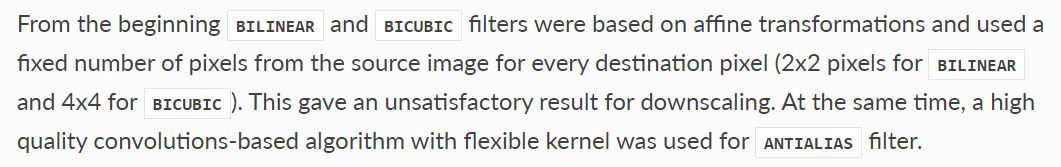

Prepare the input data by crappifying images.

Uncomment the first time you run this notebook.

In [ ]:
il = ImageList.from_folder(path_hr) #il is the imagelist from original image path.
parallel(crappify, il.items) #parallel means that applicate the function into every items one the second value. so this time, crappifier function will be applicate to il.items.

For gradual resizing we can change the commented line here.

In [ ]:
il

ImageList (7390 items)
Image (3, 500, 333),Image (3, 375, 500),Image (3, 500, 405),Image (3, 500, 333),Image (3, 319, 400)
Path: /root/.fastai/data/oxford-iiit-pet/images

In [ ]:
len(il.items)

7390

In [ ]:
7390/32   #item numbers/batch size=batch numbers.

230.9375

In [ ]:
bs,size=32, 128    #size is the image size
# bs,size = 24,160
#bs,size = 8,256

## Pre-train generator

Now let's pretrain the generator.

In [ ]:
arch = models.resnet34 #import the resnet34 models
src = ImageImageList.from_folder(path_lr).split_by_rand_pct(0.1, seed=42) #src makes the trainset and the validation set in 0.1 percentage.
#you can see 6651 items(90% of 7390) for the train
#739(10% of 7390) for the valid

In [ ]:
src

ItemLists;

Train: ImageImageList (6651 items)
Image (3, 144, 96),Image (3, 96, 128),Image (3, 118, 96),Image (3, 144, 96),Image (3, 96, 120)
Path: /root/.fastai/data/oxford-iiit-pet/crappy;

Valid: ImageImageList (739 items)
Image (3, 96, 128),Image (3, 96, 128),Image (3, 96, 128),Image (3, 143, 96),Image (3, 96, 128)
Path: /root/.fastai/data/oxford-iiit-pet/crappy;

Test: None

In [ ]:
def get_data(bs,size):
    data = (src.label_from_func(lambda x: path_hr/x.name) #get the data by label(name)
           .transform(get_transforms(max_zoom=2.), size=size, tfm_y=True) #transforming(it is kind of data augmentation)
           .databunch(bs=bs).normalize(imagenet_stats, do_y=True)) #make databunch, normalize the data

    data.c = 3 #I guess c is for the class numbers.
    return data

In [ ]:
data_gen = get_data(bs,size) #make the datasets

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3103: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3103: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpola

In [ ]:
data_gen

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3103: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3103: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpola

ImageDataBunch;

Train: LabelList (6651 items)
x: ImageImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
Path: /root/.fastai/data/oxford-iiit-pet/crappy;

Valid: LabelList (739 items)
x: ImageImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
Path: /root/.fastai/data/oxford-iiit-pet/crappy;

Test: None

In [ ]:
data_gen.c

3

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3103: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3103: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpola

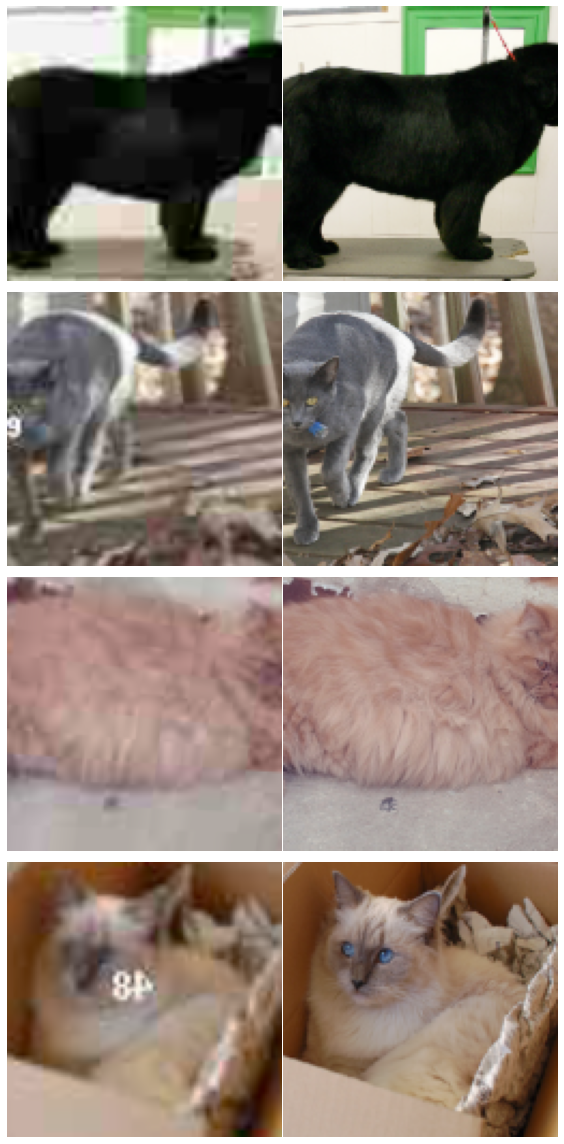

In [ ]:
data_gen.show_batch(4) #show some batch images.you can see the crappy ones with the white numbers which we made with the function, crappify

In [ ]:
wd = 1e-3 #wd means weight decay for `epochs` with `callbacks`

In [ ]:
y_range = (-3.,3.) #y range is the range for the domains of imput

In [ ]:
loss_gen = MSELossFlat() #we use MSElossfunction to calculate loss of the generator

#we use MSE for the generator, and Cross Entropi for the discriminator. 

In [ ]:
def create_gen_learner():
    return unet_learner(data_gen, arch, wd=wd, blur=True, norm_type=NormType.Weight, #build a unet learner
                         self_attention=True, y_range=y_range, loss_func=loss_gen)

In [ ]:
learn_gen = create_gen_learner() #create the gen learner

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3103: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "


In [ ]:
learn_gen.fit_one_cycle(2, pct_start=0.8) #pct_start means that the startposition in learning rate
#you can see the different curves on the graph that explains start point of finding learning rates.

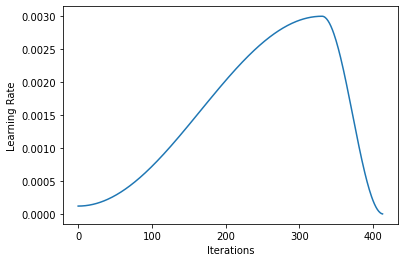

In [ ]:
learn_gen.recorder.plot_lr()

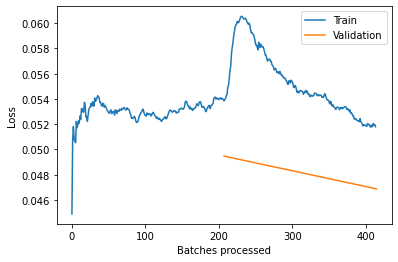

In [ ]:
learn_gen.recorder.plot_losses()

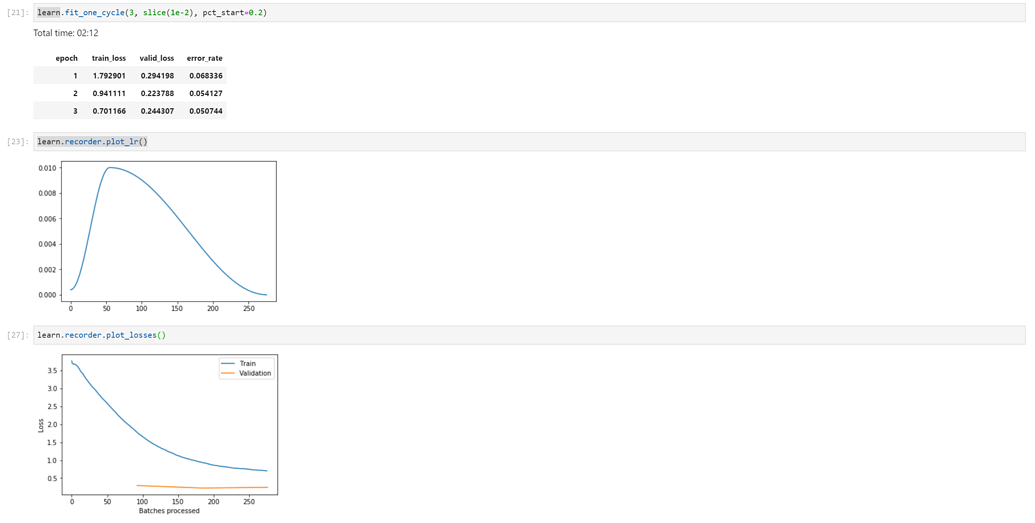

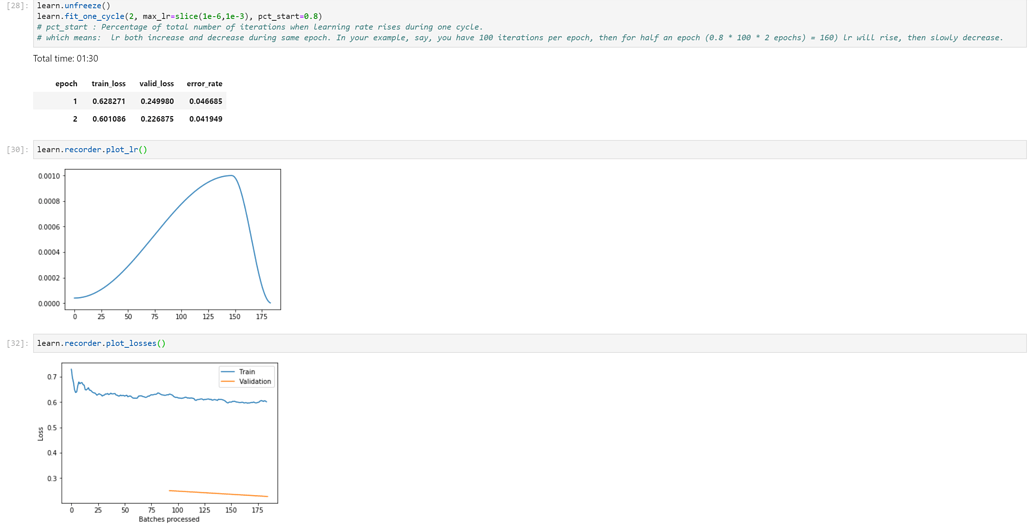

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3103: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3103: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpola

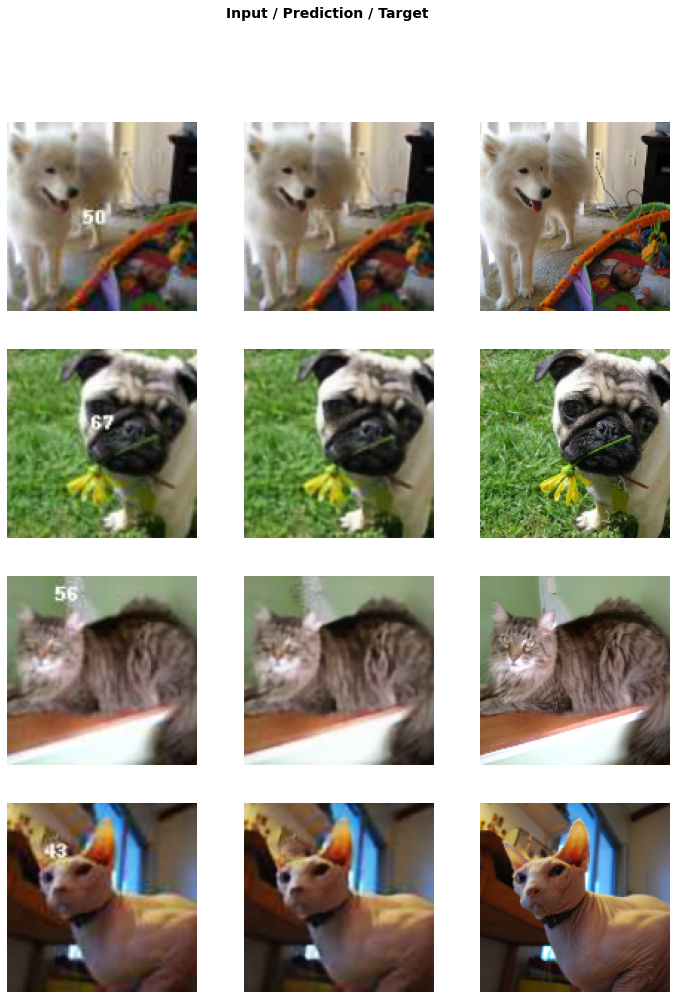

In [ ]:
learn_gen.show_results(rows=4) #this step is important. we can compare before unfreezing, and after unfreezing

In [ ]:
learn_gen.unfreeze() #unfreezing to make model more accurate

In [ ]:
learn_gen.fit_one_cycle(3, slice(1e-6,1e-3)) #slice means (start=1e-6,stop=1e-3,step=None), we change the learning rate 1e-6 to 1e-3 to find the appropriate one

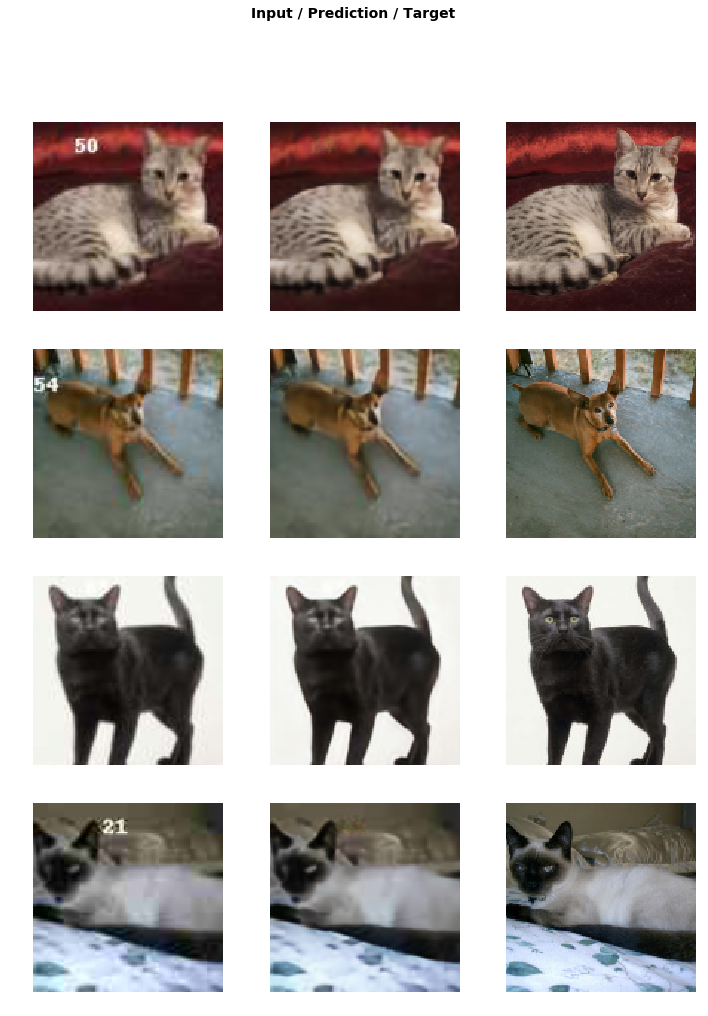

In [ ]:
learn_gen.show_results(rows=4) #show the results of the learn_gen, you can see the input,prediction and target

In [ ]:
learn_gen.save('gen-pre2') #save the learn_gan in name 'gen-pre2'

## Save generated images

In [ ]:
learn_gen.load('gen-pre2'); #load the saved one

In [ ]:
name_gen = 'image_gen' 
path_gen = path/name_gen #make path 

In [ ]:
# shutil.rmtree(path_gen)

In [ ]:
path_gen.mkdir(exist_ok=True) #make directory for the path_gen

In [ ]:
def save_preds(dl): #save the prediction ones
    i=0
    names = dl.dataset.items #names are the file names, in the datalist.
    
    for b in dl:
        preds = learn_gen.pred_batch(batch=b, reconstruct=True) #preds is for the bathces which we predicted
        for o in preds:
            o.save(path_gen/names[i].name)
            i += 1 #change i value to look over other images.

In [ ]:
save_preds(data_gen.fix_dl) #use method which we made

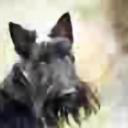

In [ ]:
PIL.Image.open(path_gen.ls()[0]) #open the sample images which in the index 0

## Train critic

In [ ]:
learn_gen=None #initiate the learn_gen model to critic
gc.collect() #gc is refers to the garbage collecter, and it is related to the initiation

3755

Pretrain the critic on crappy vs not crappy.

In [ ]:
def get_crit_data(classes, bs, size): #define the critic.
    src = ImageList.from_folder(path, include=classes).split_by_rand_pct(0.1, seed=42) #make the train set and validation set.
    ll = src.label_from_folder(classes=classes) #make the label for the dataset
    data = (ll.transform(get_transforms(max_zoom=2.), size=size) #transform, make databunches, normalize the data
           .databunch(bs=bs).normalize(imagenet_stats))
    data.c = 3 #data class are 3
    return data

In [ ]:
data_crit = get_crit_data([name_gen, 'images'], bs=bs, size=size) #make the critic model. 

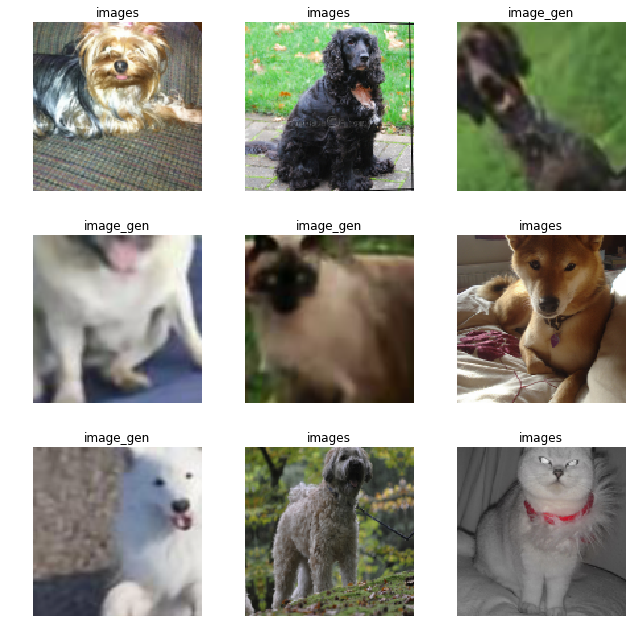

In [ ]:
data_crit.show_batch(rows=3, ds_type=DatasetType.Train, imgsize=3) #show the examples of the critic ones

In [ ]:
loss_critic = AdaptiveLoss(nn.BCEWithLogitsLoss()) #we use kind of Cross Entropy function to calculate the loss of the critic.

In [ ]:
def create_critic_learner(data, metrics): #create the critic_learner
    return Learner(data, gan_critic(), metrics=metrics, loss_func=loss_critic, wd=wd) 

In [ ]:
learn_critic = create_critic_learner(data_crit, accuracy_thresh_expand) #make the learner

In [ ]:
learn_critic.fit_one_cycle(6, 1e-3) #goes on 6 epochs for training

In [ ]:
learn_critic.save('critic-pre2') #save the critic

## GAN

Now we'll combine those pretrained model in a GAN.

In [ ]:
learn_crit=None
learn_gen=None
gc.collect() #as we did last time, we initiate things.

15794

In [ ]:
data_crit = get_crit_data(['crappy', 'images'], bs=bs, size=size) #load the critic datasets. there are crappy and original ones.

In [ ]:
learn_crit = create_critic_learner(data_crit, metrics=None).load('critic-pre2') #make the learner

In [ ]:
learn_gen = create_gen_learner().load('gen-pre2') #load the generator

To define a GAN Learner, we just have to specify the learner objects foor the generator and the critic. The switcher is a callback that decides when to switch from discriminator to generator and vice versa. Here we do as many iterations of the discriminator as needed to get its loss back < 0.5 then one iteration of the generator.

The loss of the critic is given by `learn_crit.loss_func`. We take the average of this loss function on the batch of real predictions (target 1) and the batch of fake predicitions (target 0). 

The loss of the generator is weighted sum (weights in `weights_gen`) of `learn_crit.loss_func` on the batch of fake (passed throught the critic to become predictions) with a target of 1, and the `learn_gen.loss_func` applied to the output (batch of fake) and the target (corresponding batch of superres images).

In [ ]:
switcher = partial(AdaptiveGANSwitcher, critic_thresh=0.65) #switcher makes the iteration change, discriminator into generator, and the opposite direction
learn = GANLearner.from_learners(learn_gen, learn_crit, weights_gen=(1.,50.), show_img=False, switcher=switcher,
                                 opt_func=partial(optim.Adam, betas=(0.,0.99)), wd=wd) #make the GAN learner. weights ratio is 1 : 50. 
learn.callback_fns.append(partial(GANDiscriminativeLR, mult_lr=5.)) #callback the file names appeding.

In [ ]:
lr = 1e-4 #learning rate

In [ ]:
learn.fit(40,lr) #show the losses when ephoc changes.

In [ ]:
learn.save('gan-1c') #save the gan learner

In [ ]:
learn.data=get_data(16,192) #get the data 

In [ ]:
learn.fit(10,lr/2) #show the epochs and the losses

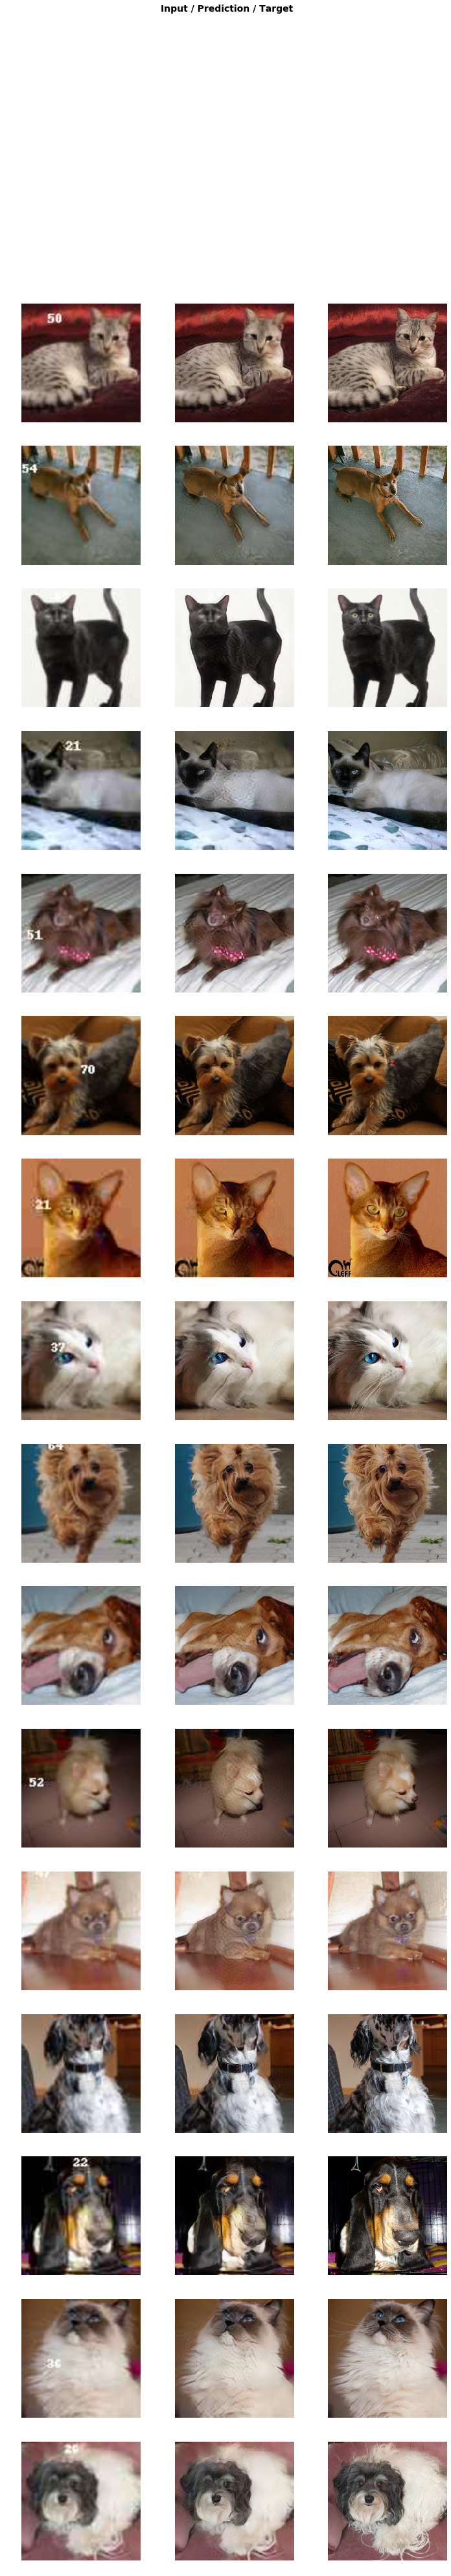

In [ ]:
learn.show_results(rows=16) #show some examples(results)

In [ ]:
learn.save('gan-1c') #save the GAN model

## fin